In [1]:
%load_ext autoreload
%autoreload 2

In [111]:
from scipy.optimize import fmin_slsqp
import numpy as np
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs

In [4]:
fr = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('results', 'oratory1990', 'harman_over-ear_2018', 'Audeze LCD-4', 'Audeze LCD-4.csv'))

In [ ]:
fr.plot_graph()

[1.97554288 1.65910992]


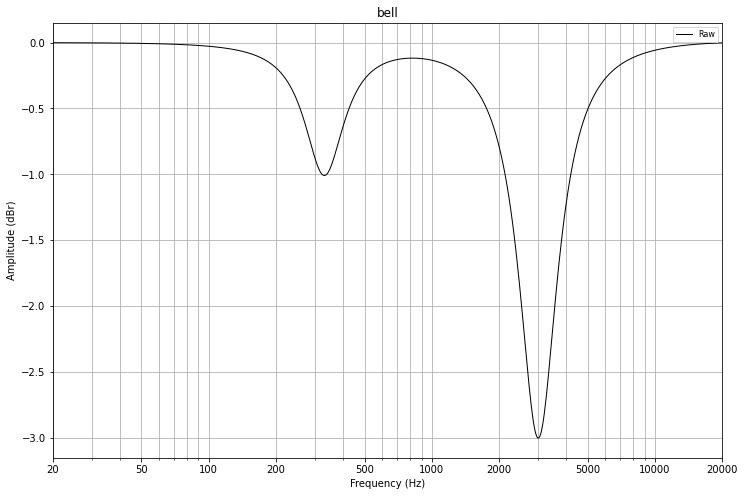

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'bell'}, xlabel='Frequency (Hz)', ylabel='Amplitude (dBr)'>)

In [21]:
fs = 48000
f = fr.frequency.copy()
a0, a1, a2, b0, b1, b2 = peaking([330, 3000], [2, 2], [-1, -3], fs=fs)
print(a1)
bell = digital_coeffs(f, fs, a0, a1, a2, b0, b1, b2, reduce=True)
_fr = FrequencyResponse(name='bell', frequency=f, raw=bell)
_fr.plot_graph()

In [92]:
def parse_coeffs(coeffs):
    coeffs = np.reshape(coeffs, (3, len(coeffs) // 3))
    fc = 10**coeffs[0, :]
    q = np.abs(coeffs[1, :])
    gain = coeffs[2, :]
    return fc, q, gain  # Center frequency is optimized as logarithmic variable

In [104]:
def loss(pars, fs, f, target):
    fc, q, gain = parse_coeffs(pars)
    a0, a1, a2, b0, b1, b2 = peaking(fc, q, gain, fs=fs)
    estimate = digital_coeffs(f, fs, a0, a1, a2, b0, b1, b2, reduce=True)
    loss_val = np.mean(np.square(target - estimate))
    return loss_val

In [105]:
def init_guess(n):
    f_max = np.log10(20e3)
    f_min = np.log10(20)
    f_step = (f_max - f_min) / n
    fc = np.linspace(f_min + f_step / 2, f_max - f_step / 2, n)  # Space center frequencies evenly across the total range
    bw = np.log10(20e3 / 20) / np.log10(2) / n  # Filter bandwidth is total range (~10 octaves) divided by number of filters
    q = np.sqrt(2**bw) / (2**bw - 1)  # Same initial quality for all filters
    q = [q] * n
    gain = [0.0] * n
    return np.concatenate([fc, q, gain])

In [191]:
def optimize(fr, n, fs):
    if np.isscalar(n):
        n = np.array([n])
    fc = np.array([])
    q = np.array([])
    gain = np.array([])
    peq_fr = np.zeros(fr.frequency.shape)
    for n_filters in n:
        guess = init_guess(n_filters)
        par = fmin_slsqp(loss, guess, args=(fs, fr.frequency, fr.equalization - peq_fr), iter=min(25, 2 * n_filters), iprint=0)
        _fc, _q, _gain = parse_coeffs(par)
        peq_fr += digital_coeffs(fr.frequency, fs, *peaking(_fc, _q, _gain, fs=fs), reduce=True)
        fc = np.concatenate([fc, _fc])
        q = np.concatenate([q, _q])
        gain = np.concatenate([gain, _gain])
    return fc, q, gain, peq_fr

New 0.0940 s
Old 10.6616 s
RMSE 49.03 -> 0.52  = -48.50 dB (-98.9 %)


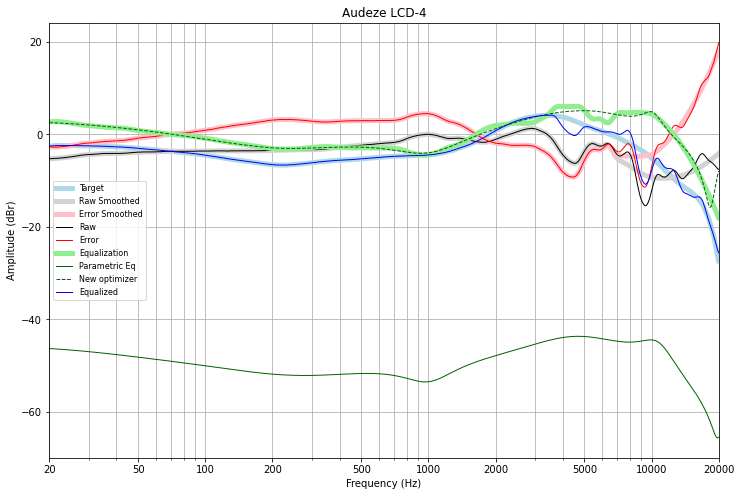

(<Figure size 864x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Audeze LCD-4'}, xlabel='Frequency (Hz)', ylabel='Amplitude (dBr)'>)

In [196]:
n = [5, 5, 5]
t = time()
fc, q, gain, peq_fr = optimize(fr, n, 48000)
print(f'New {time() - t:.4f} s')
fr.fixed_band_eq = peq_fr
t = time()
fr.optimize_parametric_eq(max_filters=n)
print(f'Old {time() - t:.4f} s')
ix = np.sum(fr.frequency < 10e3)
new_mse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.fixed_band_eq[:ix])))
old_mse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix])))
print(f'RMSE {old_mse:.2f} -> {new_mse:.2f}  = {"+" if new_mse > old_mse else ""}{new_mse - old_mse:.2f} dB ({(new_mse - old_mse) / old_mse * 100:.1f} %)')
fr.plot_graph(fixed_band_eq_plot_kwargs={'label': 'New optimizer'}, show=True)